# Experiments with Progressive GANs

## Setup

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1xbb2xakSn22lZoUcdaydQaBHoBSiUt6T'
X = drive.CreateFile({'id': file_id})
X = X.GetContentFile('m')

     |████████████████████████████████| 993kB 3.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
file_id = '1xbb2xakSn22lZoUcdaydQaBHoBSiUt6T'
X = drive.CreateFile({'id': file_id})
X = X.GetContentFile('m')

AttributeError: ignored

## Imports

In [37]:
# Imports
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
from IPython.display import Image, display
import os
from google.colab import files

# Start TF session
tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Utils

In [0]:
# Saves model on remote PC
def get_model(name):
  if name == "lsun_bird":
    file_id = '1xce6ct41eKxTjyASRsKY8erSikFpVWG5'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_bird.pkl')
  elif name == 'lsun_bedroom':
    file_id = '1xbb2xakSn22lZoUcdaydQaBHoBSiUt6T'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_bedroom.pkl')
  elif name == 'lsun_tower':
    file_id = '1z8gUcWvUxtAjKhCzr88BO62NFBLYQ32G'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_bedroom.pkl')
  elif name == 'lsun_church':
    file_id = '1yGlooC5u4KuiOMzuJiA1W-MW4WB-wqnf'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_lsun_church.pkl')
  elif name == "celeb":
    file_id = '188K19ucknC6wg1R6jbuPEhTq9zoufOx4'
    X = drive.CreateFile({'id': file_id})
    X = X.GetContentFile('model_celeb.pkl')

# Loads model
def load_model(name):
  get_model(name)
  with open('model_' + name + '.pkl', 'rb') as f:
    G, D, Gs = pickle.load(f)
  return G, D, Gs

In [0]:
# Generate images (size: number of images to be generated)
# Keep partition_size < 100
def generate_images(G, D, Gs, size, partition_size):
  # Generate latent vectors.
  latents = np.random.randn(size, *Gs.input_shapes[0][1:])
  
  # Generate dummy labels (not used by the official networks).
  labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
  images = np.zeros((size, 3, 256, 256))
  
  # Generation is done in batches of 100 or less because Colab seems to crash with more images (lack of GPU memory)
  partitions = int(size/partition_size)
  for p in range(partitions):
    images[p*partition_size : (p+1)*partition_size] = Gs.run(latents[p*partition_size : (p+1)*partition_size], labels[p*partition_size : (p+1)*partition_size])
    
  # Convert images to PIL-compatible format.
  images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
  images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
  
  return images

In [0]:
def euclidean_dist(a, b):
  return np.sum(np.square(a-b))

def get_distances(arr):
  l = len(arr)
  dist = []
  
  for i in range(l):
    for j in range(l):
      if i < j:
        dist.append((euclidean_dist(arr[i], arr[j]), i, j))
    
    # Print something to show progress
    if i%200 == 0:
      print("Pairs with image {} done".format(i))
  return dist

# Get top 20 closest pairs from generated images (returns a list of 20 tuples which are later used for display) 
def get_top_20(images):
  print("Calculating Pair wise Distances")
  dist = get_distances(images)
  print("Retrieving top 20 pairs")
  dist.sort(key = lambda tup:tup[0])
  return dist[:20]

In [0]:
# Display the top 20 pairs using the list generated from get_top_20()
def show_top_20(d, img):
  images = []
  
  i = 0
  for tup in d:
    images.append(img[tup[1]])
    images.append(img[tup[2]])
    i = i + 2
    
  # Save images as PNG.
  for idx in range(len(images)):
    PIL.Image.fromarray(images[idx], 'RGB').save('img%d.png' % idx)
  
  # Display pairs (each separated by a new line and "Pair")
  listOfImageNames = ['img%d.png' % idx for idx in range(40)]
  
  i = 0
  for imageName in listOfImageNames:
    if i % 2 == 0:
      print("\n\nPair")
    display(Image(filename=imageName))
    i = i + 1
    
  for imagename in listOfImageNames:
    files.download(imagename)
    os.remove(imagename)

In [0]:
# Note size should be a multiple of 50 (lower granularity is probably not worth it)
def bp_test(G, D, Gs, size):
  batches = int(size/1000)
  
  # Generate Images
  images = np.zeros((size, 256, 256, 3))
  for i in range(batches):
    images[i*1000 : (i+1)*1000] = generate_images(G, D, Gs, 1000, 100)
  images[batches*1000 : ] = generate_images(G, D, Gs, size - (batches*1000), 100)
  print("Generation Done")
    
  return images

## Clone Repo and Pretrained models

In [7]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git

Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 350.22 KiB | 4.22 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [0]:
# Required for pickle.load()
!cp progressive_growing_of_gans/tfutil.py .

## Birthday Paradox Test on LSUN Bedrooms (approx 3 million images)

In [0]:
with open('./drive/My Drive/karras2018iclr-lsun-bedroom-256x256.pkl', 'rb') as f:
  G, D, Gs = pickle.load(f)
  
images = generate_images(G, D, Gs, 1000, 50)
images1 = generate_images(G, D, Gs, 1000, 50)
#images2 = generate_images(G, D, Gs, 1000, 50)
#images3 = generate_images(G, D, Gs, 1000, 50)

In [28]:
# Get Top 20 pairs
#d = get_top_20(np.concatenate((images, images1, images2, images3)))
d = get_top_20(np.concatenate((images, images1)))

Calculating Pair wise Distances
Pairs with image 0 done
Pairs with image 200 done
Pairs with image 400 done
Pairs with image 600 done
Pairs with image 800 done
Pairs with image 1000 done
Pairs with image 1200 done
Pairs with image 1400 done
Pairs with image 1600 done
Pairs with image 1800 done
Retrieving top 20 pairs




Pair


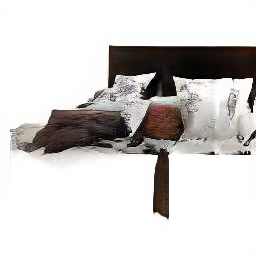

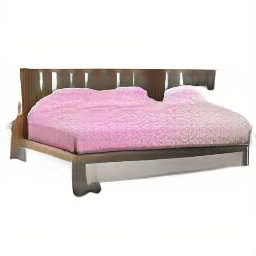



Pair


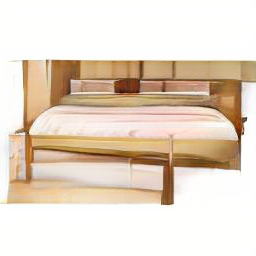

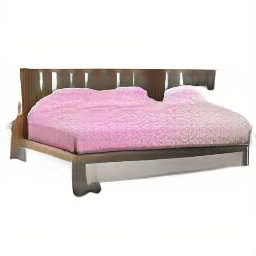



Pair


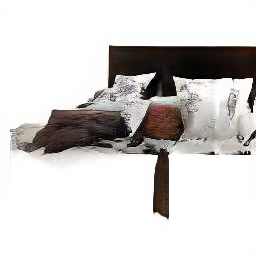

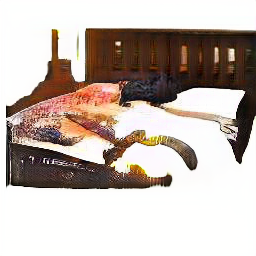



Pair


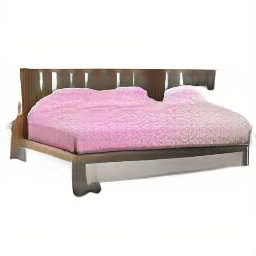

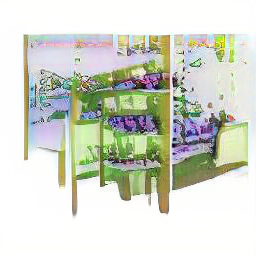



Pair


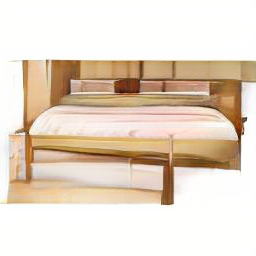

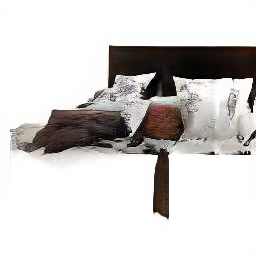



Pair


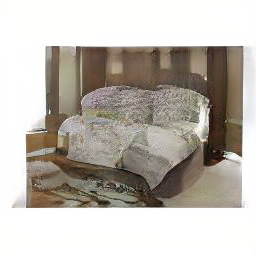

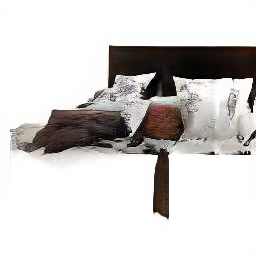



Pair


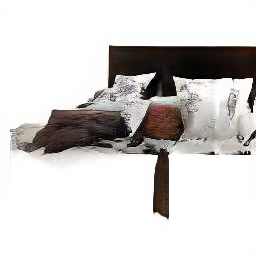

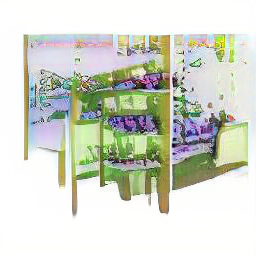



Pair


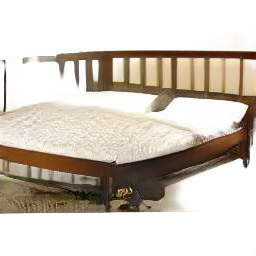

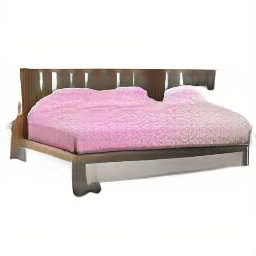



Pair


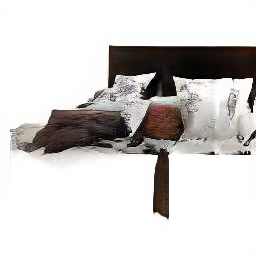

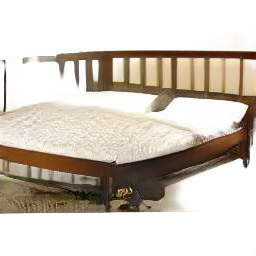



Pair


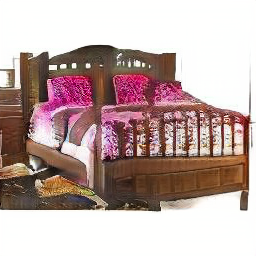

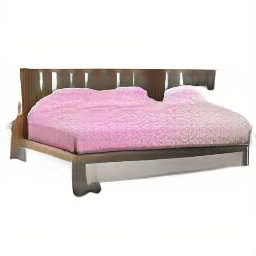



Pair


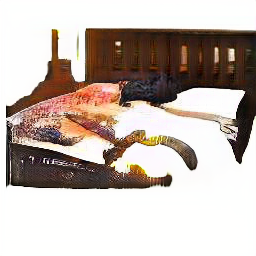

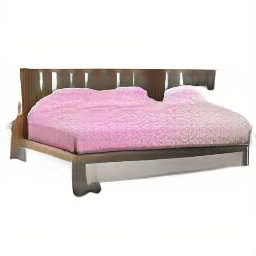



Pair


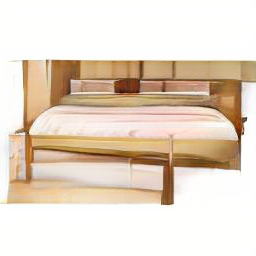

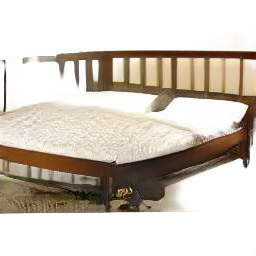



Pair


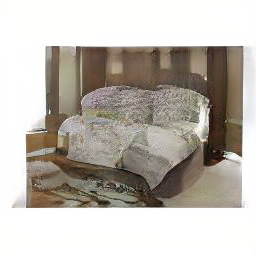

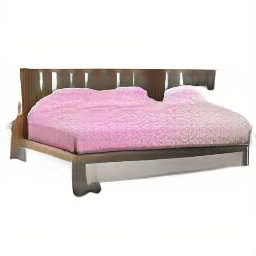



Pair


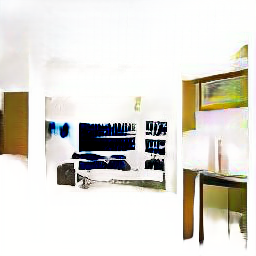

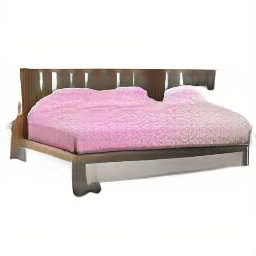



Pair


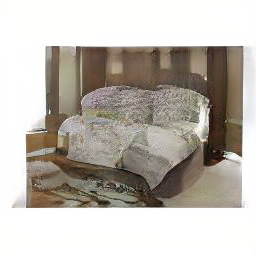

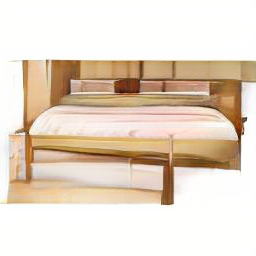



Pair


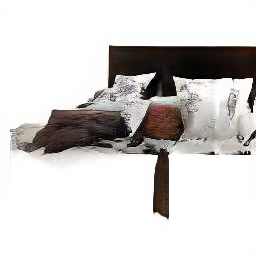

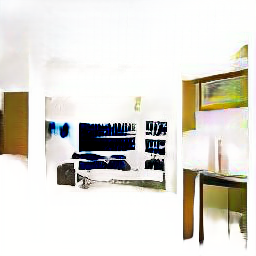



Pair


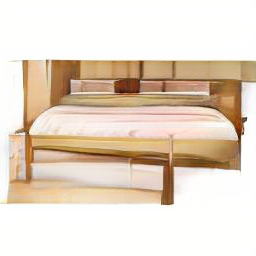

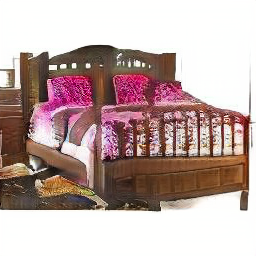



Pair


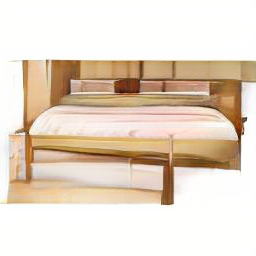

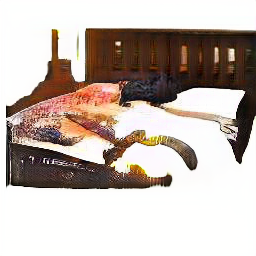



Pair


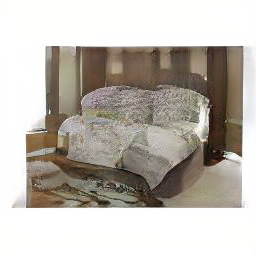

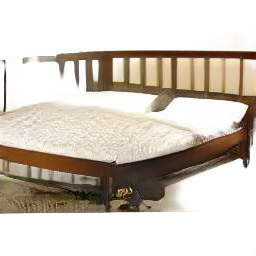



Pair


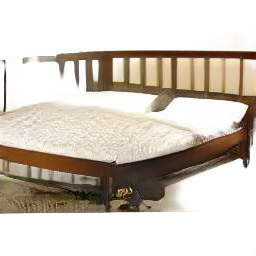

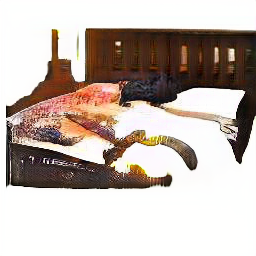

In [31]:
show_top_20(d, np.concatenate((images, images1)))

## Birthday Paradox test on LSUN Birds (approx 2 million images)

### Max support size : 4 million (2x of dataset)

Calculating Pair wise Distances
Pairs with image 0 done
Pairs with image 200 done
Pairs with image 400 done
Pairs with image 600 done
Pairs with image 800 done
Pairs with image 1000 done
Pairs with image 1200 done
Pairs with image 1400 done
Pairs with image 1600 done
Pairs with image 1800 done
Retrieving top 20 pairs


Pair


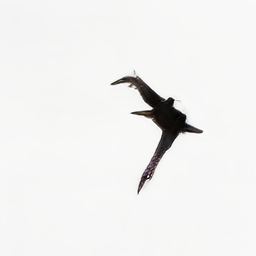

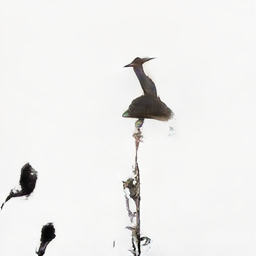



Pair


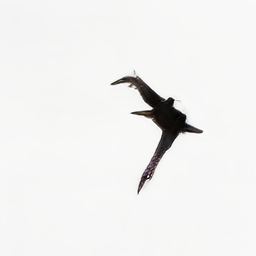

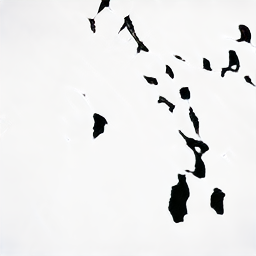



Pair


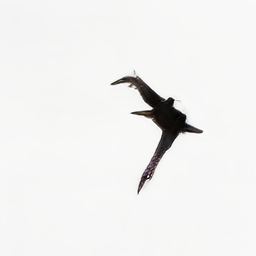

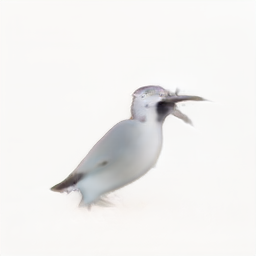



Pair


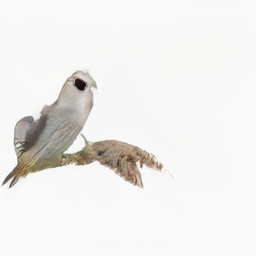

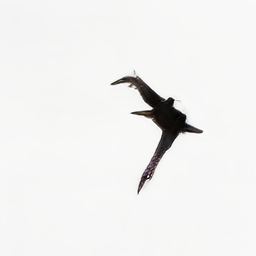



Pair


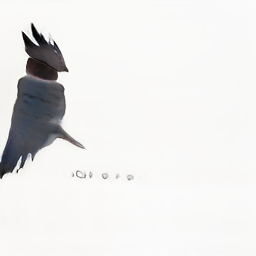

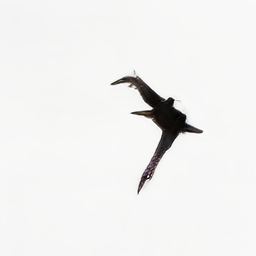



Pair


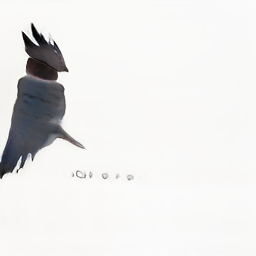

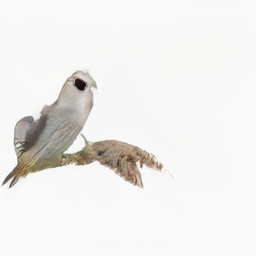



Pair


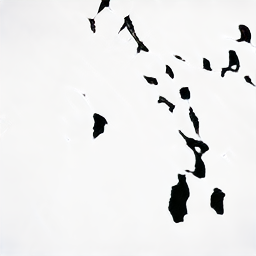

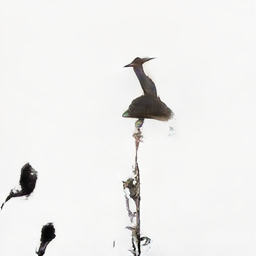



Pair


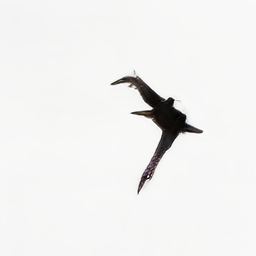

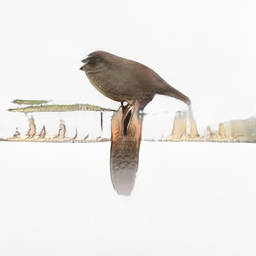



Pair


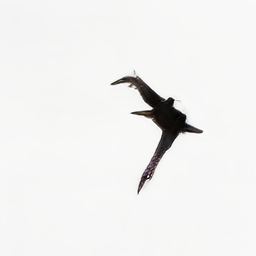

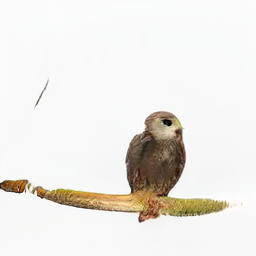



Pair


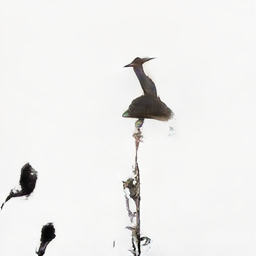

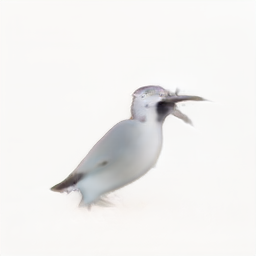



Pair


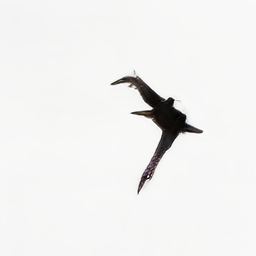

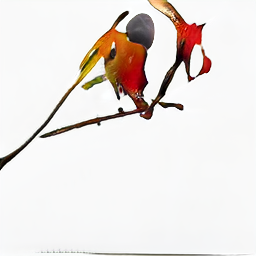



Pair


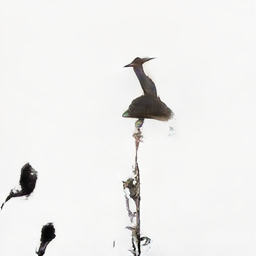

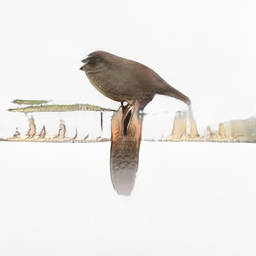



Pair


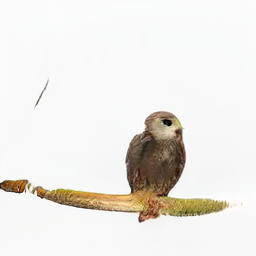

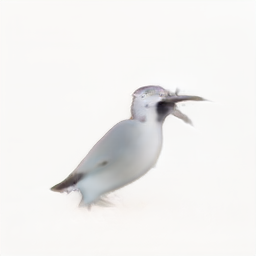



Pair


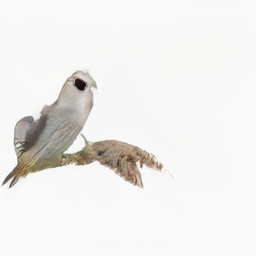

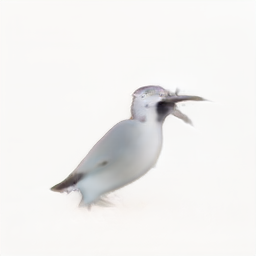



Pair


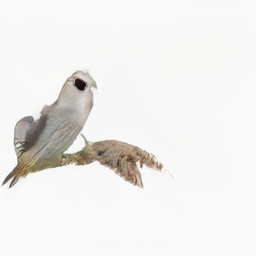

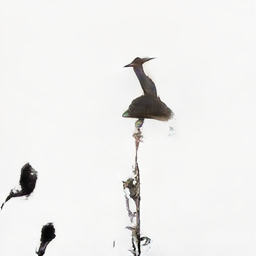



Pair


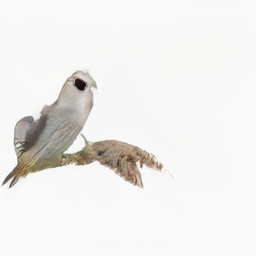

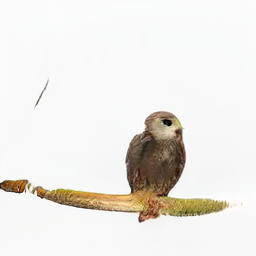



Pair


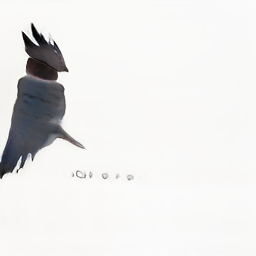

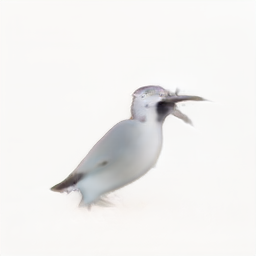



Pair


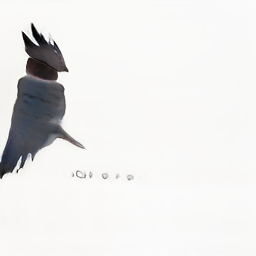

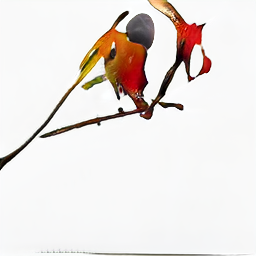



Pair


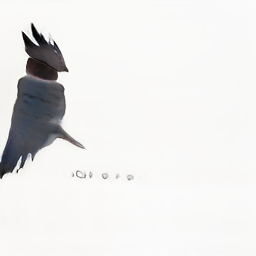

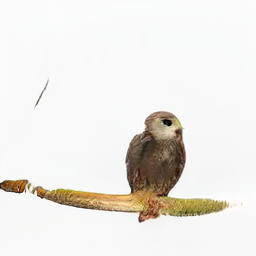



Pair


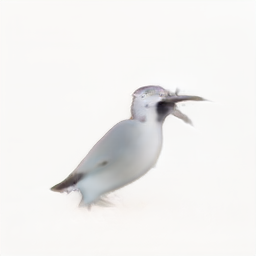

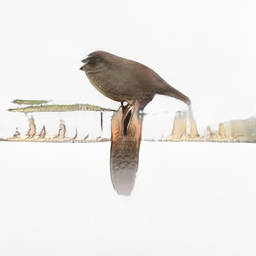

MessageError: ignored

In [39]:
with open('./drive/My Drive/karras2018iclr-lsun-bird-256x256.pkl', 'rb') as f:
  G, D, Gs = pickle.load(f)
  
images = generate_images(G, D, Gs, 1000, 50)
images1 = generate_images(G, D, Gs, 1000, 50)

d = get_top_20(np.concatenate((images, images1)))

show_top_20(d, np.concatenate((images, images1)))

### Max support size : 9 million ( 4.5x of dataset)

Calculating Pair wise Distances
Pairs with image 0 done
Pairs with image 200 done
Pairs with image 400 done
Pairs with image 600 done
Pairs with image 800 done
Pairs with image 1000 done
Pairs with image 1200 done
Pairs with image 1400 done
Pairs with image 1600 done
Pairs with image 1800 done
Pairs with image 2000 done
Pairs with image 2200 done
Pairs with image 2400 done
Pairs with image 2600 done
Pairs with image 2800 done
Retrieving top 20 pairs


Pair


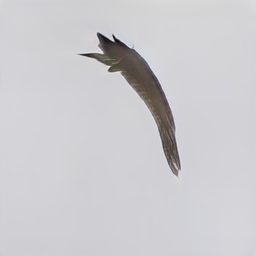

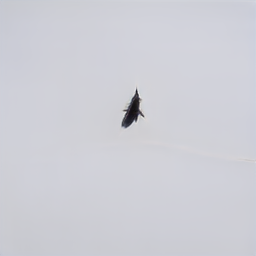



Pair


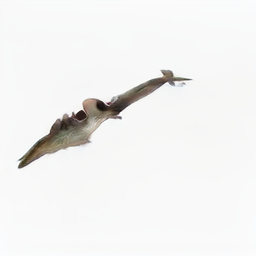

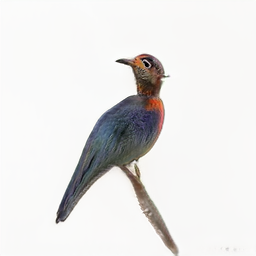



Pair


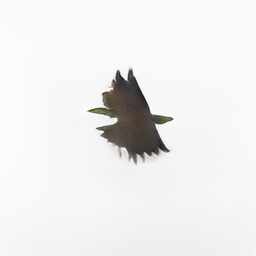

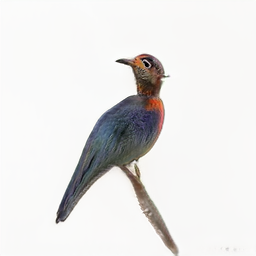



Pair


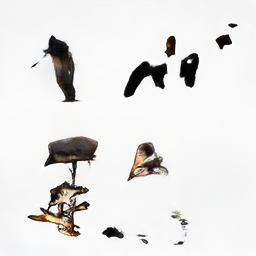

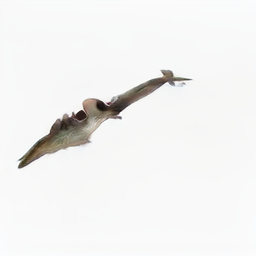



Pair


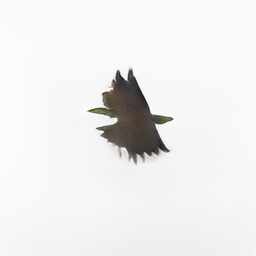

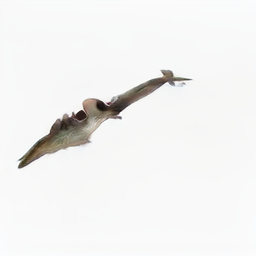



Pair


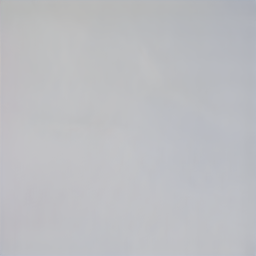

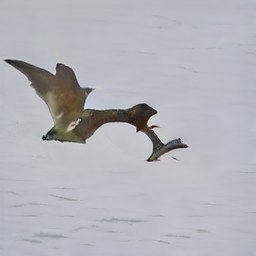



Pair


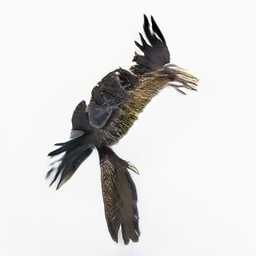

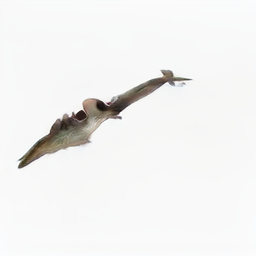



Pair


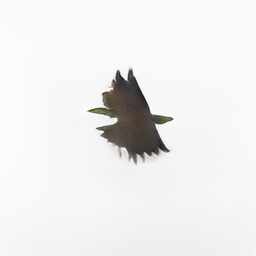

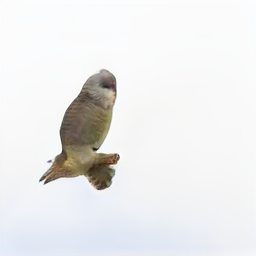



Pair


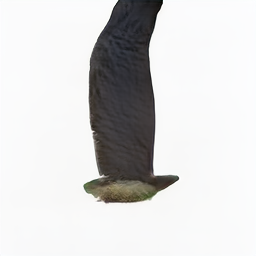

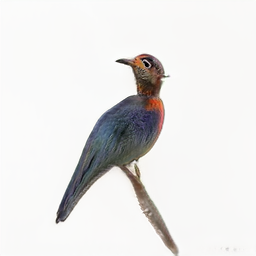



Pair


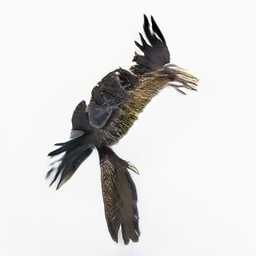

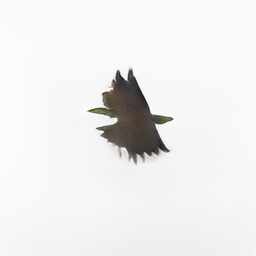



Pair


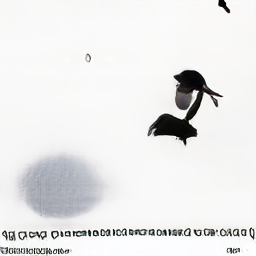

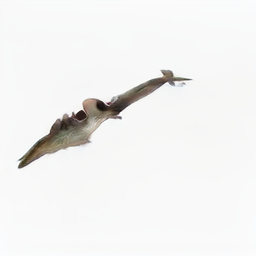



Pair


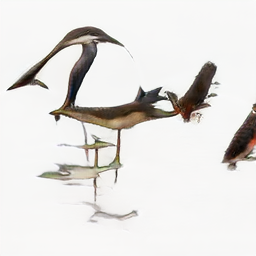

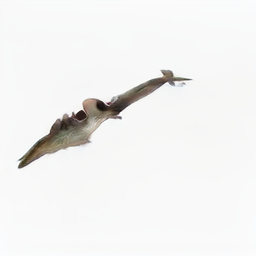



Pair


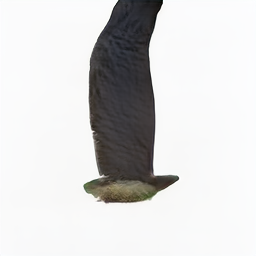

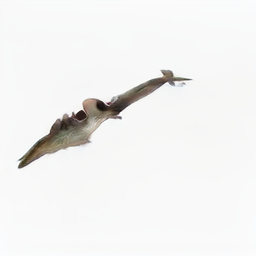



Pair


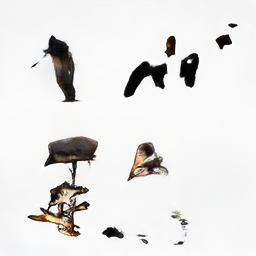

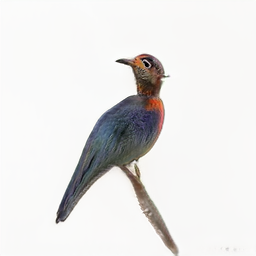



Pair


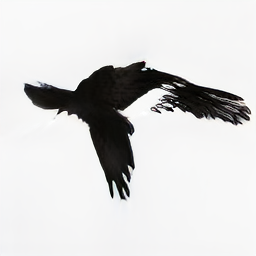

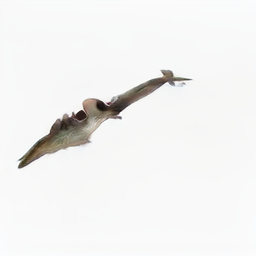



Pair


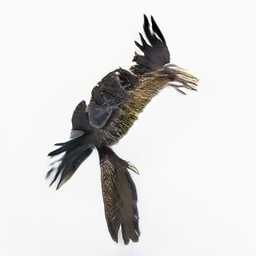

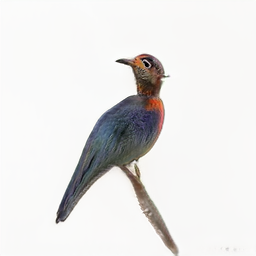



Pair


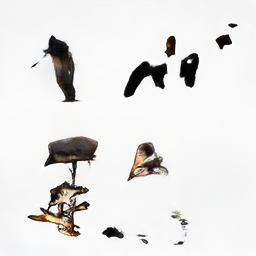

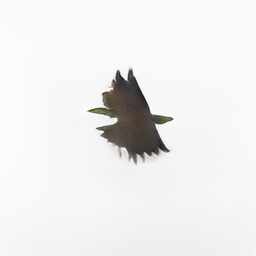



Pair


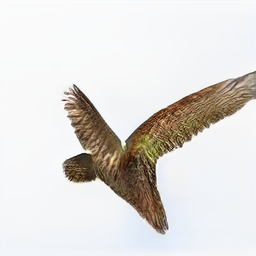

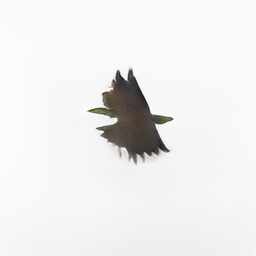



Pair


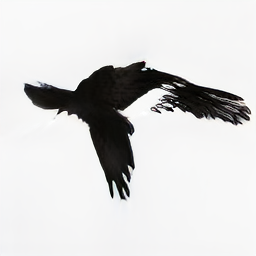

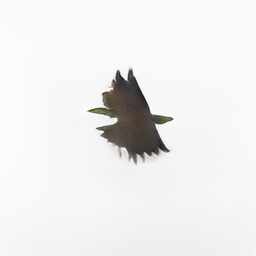



Pair


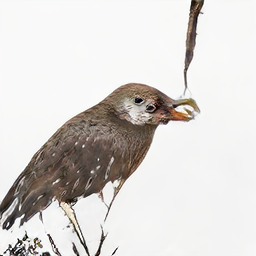

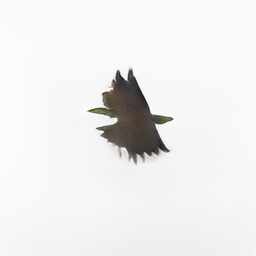

In [36]:
with open('./drive/My Drive/karras2018iclr-lsun-bird-256x256.pkl', 'rb') as f:
  G, D, Gs = pickle.load(f)
  
images = generate_images(G, D, Gs, 1000, 50)
images1 = generate_images(G, D, Gs, 1000, 50)
images2 = generate_images(G, D, Gs, 1000, 50)

d = get_top_20(np.concatenate((images, images1, images2)))

show_top_20(d, np.concatenate((images, images1, images2)))

### Max support size : 16 million ( 8x of dataset)

Calculating Pair wise Distances
Pairs with image 0 done
Pairs with image 200 done
Pairs with image 400 done
Pairs with image 600 done
Pairs with image 800 done
Pairs with image 1000 done
Pairs with image 1200 done
Pairs with image 1400 done
Pairs with image 1600 done
Pairs with image 1800 done
Pairs with image 2000 done
Pairs with image 2200 done
Pairs with image 2400 done
Pairs with image 2600 done
Pairs with image 2800 done
Pairs with image 3000 done
Pairs with image 3200 done
Pairs with image 3400 done
Pairs with image 3600 done
Pairs with image 3800 done
Retrieving top 20 pairs


Pair


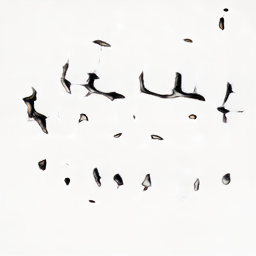

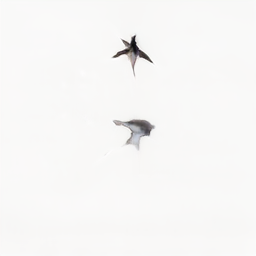



Pair


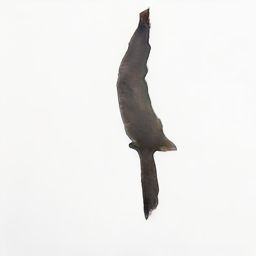

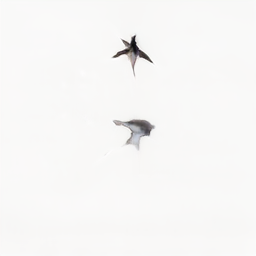



Pair


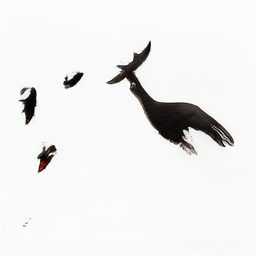

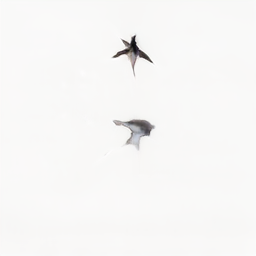



Pair


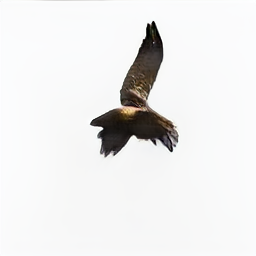

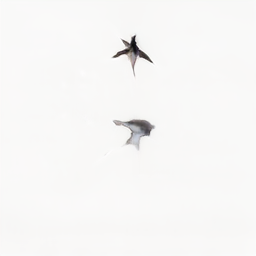



Pair


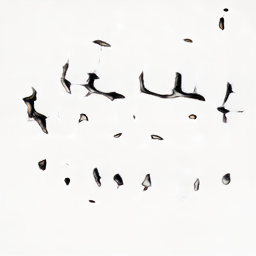

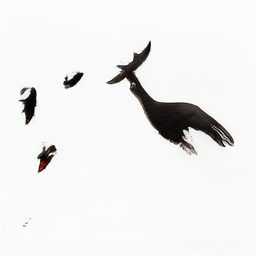



Pair


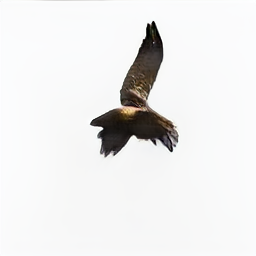

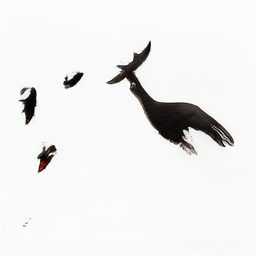



Pair


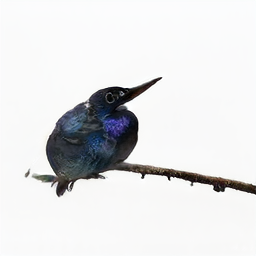

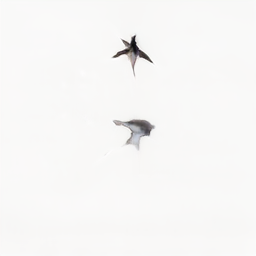



Pair


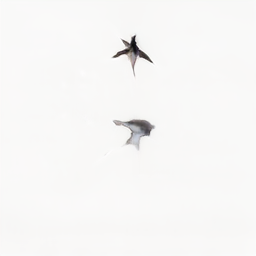

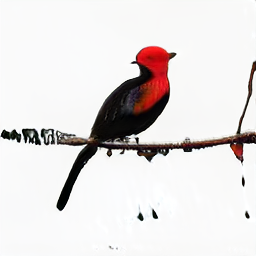



Pair


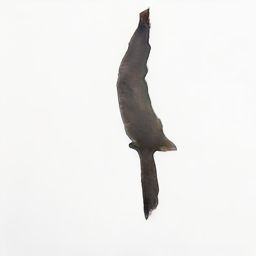

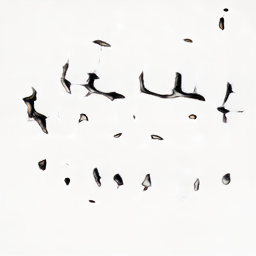



Pair


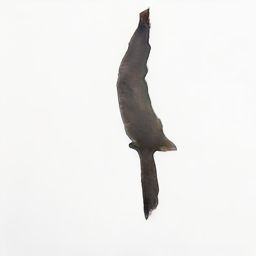

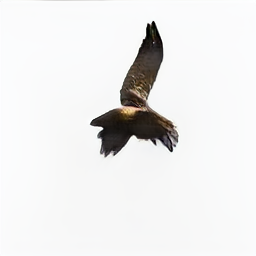



Pair


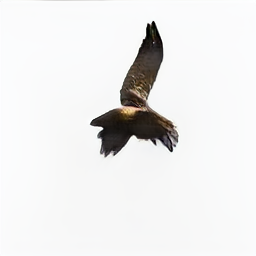

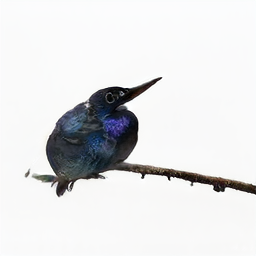



Pair


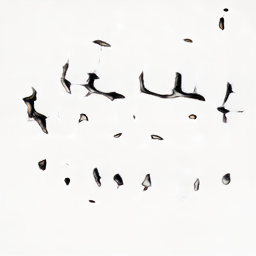

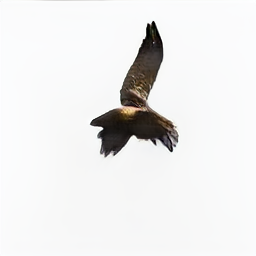



Pair


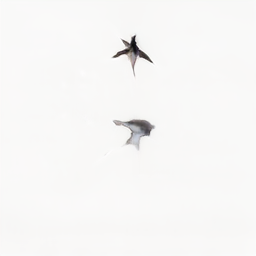

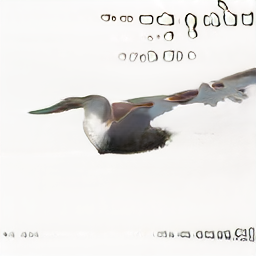



Pair


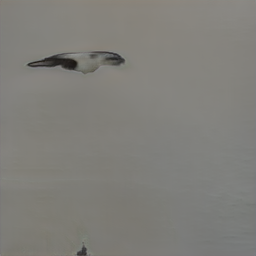

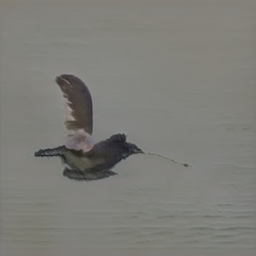



Pair


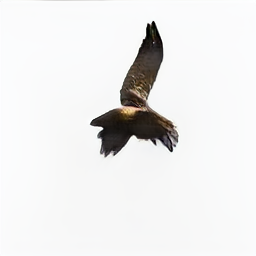

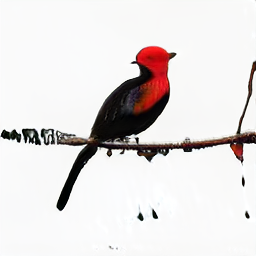



Pair


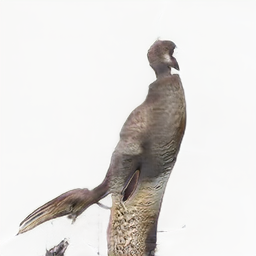

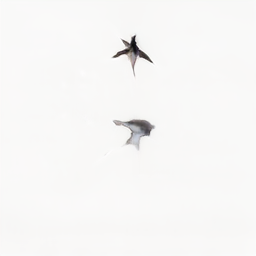



Pair


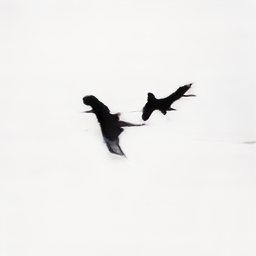

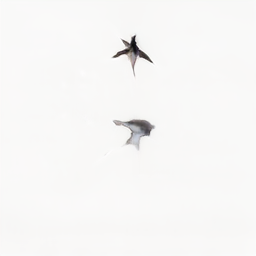



Pair


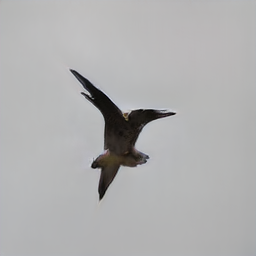

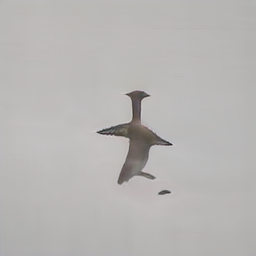



Pair


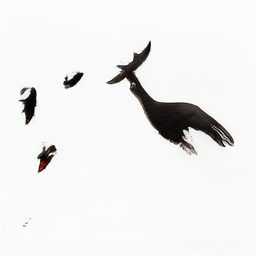

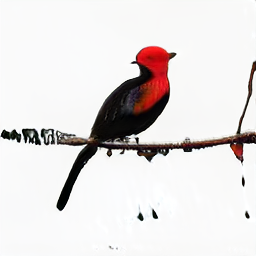



Pair


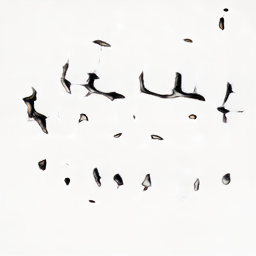

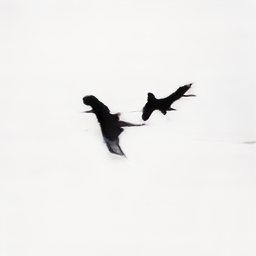

MessageError: ignored

In [40]:
with open('./drive/My Drive/karras2018iclr-lsun-bird-256x256.pkl', 'rb') as f:
  G, D, Gs = pickle.load(f)
  
images = generate_images(G, D, Gs, 1000, 50)
images1 = generate_images(G, D, Gs, 1000, 50)
images2 = generate_images(G, D, Gs, 1000, 50)
images3 = generate_images(G, D, Gs, 1000, 50)

d = get_top_20(np.concatenate((images, images1, images2, images3)))

show_top_20(d, np.concatenate((images, images1, images2, images3)))

## Notes


*   Returns pairs with large portions of the image containing the background. (with euclidean distance metric)
*   Difficult to evaluate on datasets with a single class when euclidean distance does not work
* Future work : Train binary CNN classifier and use embeddings as distance metric 

